In [13]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn import preprocessing
import klib
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler

## Loading Data

In [3]:
#Get path
current_directory = os.getcwd()
current_directory

df = pd.read_csv(current_directory+'/datasets/df_prediction.csv')

In [4]:
#Review Dataset
df

,player,year_month,sent_pga,pga_lag1,pga_lag2,pga_lag3,sent_liv,sent_both,LIV_CHANGE
0,brooks koepka,2020-11-01,0.958400,NaN,NaN,NaN,0.651700,NaN,0
1,brooks koepka,2021-02-01,0.790600,0.958400,NaN,NaN,0.839250,NaN,0
2,brooks koepka,2021-04-01,0.670867,0.790600,0.958400,NaN,NaN,NaN,0
3,brooks koepka,2021-06-01,0.851413,0.670867,0.790600,0.9584,0.102600,0.96230,0
4,brooks koepka,2021-07-01,0.423000,0.851413,0.670867,0.7906,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
254,sergio garcia,2023-04-01,NaN,NaN,NaN,NaN,0.607133,0.83260,0
255,sergio garcia,2023-05-01,0.870600,0.557400,0.732300,0.3753,0.992900,0.99065,0
256,sergio garcia,2023-06-01,NaN,NaN,NaN,NaN,0.517933,0.90610,0
257,sergio garcia,2023-08-01,NaN,NaN,NaN,NaN,0.970775,0.92170,0


## Imputing Missing Values

In [5]:
df.isna().mean()

player        0.000000
year_month    0.000000
sent_pga      0.200772
pga_lag1      0.243243
pga_lag2      0.285714
pga_lag3      0.328185
sent_liv      0.281853
sent_both     0.679537
LIV_CHANGE    0.000000
dtype: float64

In [6]:
# Fill missing values using interpolate
df['sent_pga'] = df.groupby('player')['sent_pga'].transform(lambda x: x.interpolate(method='linear'))
df['sent_liv'] = df.groupby('player')['sent_liv'].transform(lambda x: x.interpolate(method='linear'))

#Fill missing values using backfill and forwardfill
df['pga_lag1'] = df.groupby('player')['pga_lag1'].transform(lambda x: x.ffill().bfill())
df['pga_lag2'] = df.groupby('player')['pga_lag2'].transform(lambda x: x.ffill().bfill())
df['pga_lag3'] = df.groupby('player')['pga_lag3'].transform(lambda x: x.ffill().bfill())

In [7]:
#Fill missing values using backfill and forwardfill
df['sent_pga'] = df.groupby('player')['sent_pga'].transform(lambda x: x.ffill().bfill())
df['sent_liv'] = df.groupby('player')['sent_liv'].transform(lambda x: x.ffill().bfill())

In [8]:
# Remove sent_both and interaction and percentage changes
df = df.drop(['sent_both'], axis=1)

In [9]:
df.isna().mean()

player        0.0
year_month    0.0
sent_pga      0.0
pga_lag1      0.0
pga_lag2      0.0
pga_lag3      0.0
sent_liv      0.0
LIV_CHANGE    0.0
dtype: float64

## Feature Engineering

In [10]:
## Creating a interaction between current and previous months 
## We will like to measure the impact of the whole 3 month periods and not just individual months
df

,player,year_month,sent_pga,pga_lag1,pga_lag2,pga_lag3,sent_liv,LIV_CHANGE
0,brooks koepka,2020-11-01,0.958400,0.958400,0.958400,0.9584,0.651700,0
1,brooks koepka,2021-02-01,0.790600,0.958400,0.958400,0.9584,0.839250,0
2,brooks koepka,2021-04-01,0.670867,0.790600,0.958400,0.9584,0.470925,0
3,brooks koepka,2021-06-01,0.851413,0.670867,0.790600,0.9584,0.102600,0
4,brooks koepka,2021-07-01,0.423000,0.851413,0.670867,0.7906,0.484200,0
...,...,...,...,...,...,...,...,...
254,sergio garcia,2023-04-01,0.714000,0.732300,0.375300,0.8704,0.607133,0
255,sergio garcia,2023-05-01,0.870600,0.557400,0.732300,0.3753,0.992900,0
256,sergio garcia,2023-06-01,0.870600,0.557400,0.732300,0.3753,0.517933,0
257,sergio garcia,2023-08-01,0.870600,0.557400,0.732300,0.3753,0.970775,0


Text(0.5, 1.0, 'Correlation Matrix (Quantitative Variables)')

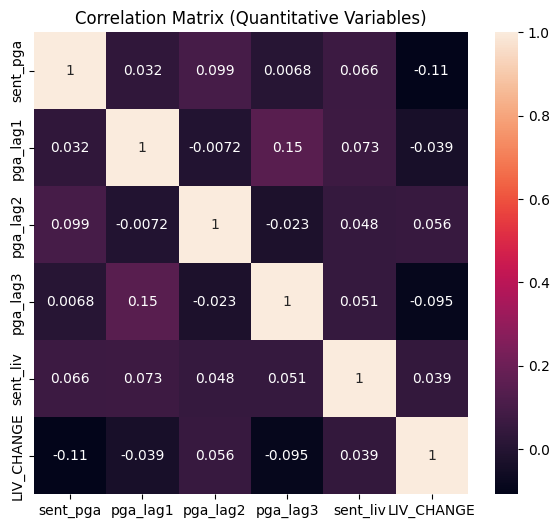

In [11]:
# Correlations among the variables 
df_for_heatmap = df.drop(columns=['player', 'year_month'])
df_for_heatmap_corr = df_for_heatmap.corr()

# Plot correlations
fig, ax = plt.subplots(figsize=(7,6))
ax = sns.heatmap(df_for_heatmap_corr, annot = True, )
plt.title('Correlation Matrix (Quantitative Variables)')

<Axes: title={'center': 'Feature-correlation (pearson)'}>

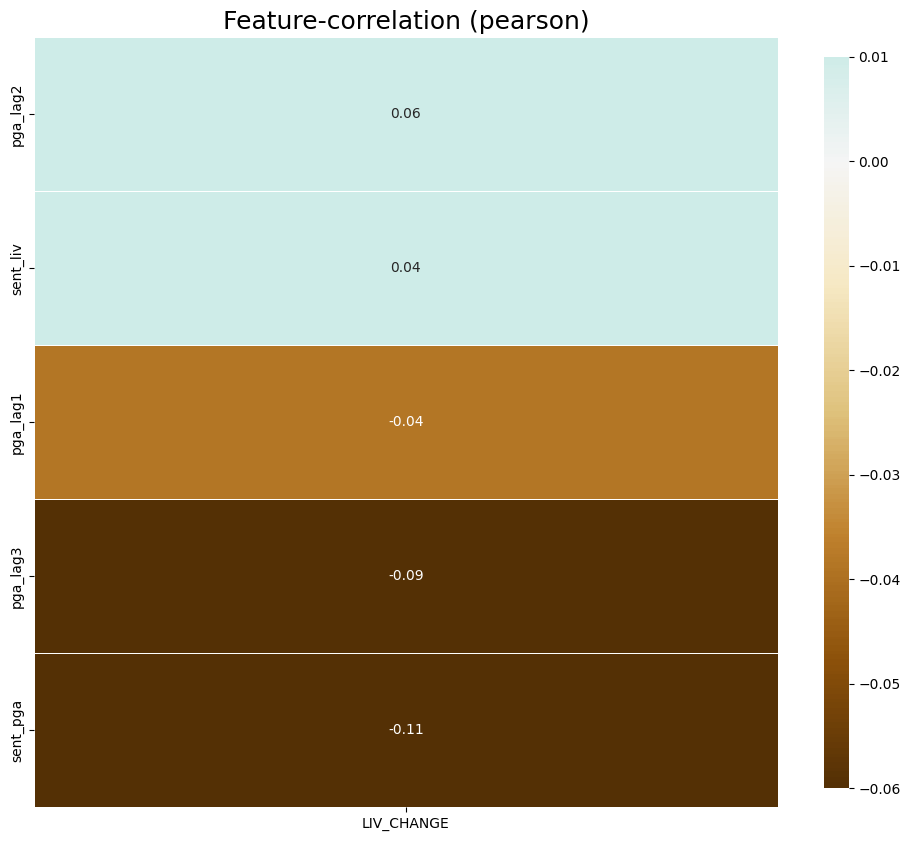

In [14]:

klib.corr_plot(df_for_heatmap, target='LIV_CHANGE') # default representation of correlations with the feature column

In [12]:
df.head()

,player,year_month,sent_pga,pga_lag1,pga_lag2,pga_lag3,sent_liv,LIV_CHANGE
0,brooks koepka,2020-11-01,0.958400,0.958400,0.958400,0.9584,0.651700,0
1,brooks koepka,2021-02-01,0.790600,0.958400,0.958400,0.9584,0.839250,0
2,brooks koepka,2021-04-01,0.670867,0.790600,0.958400,0.9584,0.470925,0
3,brooks koepka,2021-06-01,0.851413,0.670867,0.790600,0.9584,0.102600,0
4,brooks koepka,2021-07-01,0.423000,0.851413,0.670867,0.7906,0.484200,0


In [15]:

# In case we use directly a Train and Test datatset
Xtrain_id = df[['player','year_month']]
Xtrain = df.drop(['player','year_month','LIV_CHANGE'],axis = 1)
ytrain = df['LIV_CHANGE']

### Balancing Classes

In [16]:
ytrain.value_counts()

LIV_CHANGE
0    254
1      5
Name: count, dtype: int64

### Re balancing for a better classification

In [18]:
#smt = SMOTETomek(sampling_strategy=0.50)
#X_res, y_res = smt.fit_resample(Xtrain, ytrain)

desired_ratio = 0.25

# Instantiate the RandomOverSampler with the desired ratio
oversampler = RandomOverSampler(sampling_strategy=desired_ratio, random_state=42)

# Perform random oversampling
X_train_resampled, y_train_resampled = oversampler.fit_resample(Xtrain, ytrain)

In [19]:
y_train_resampled.value_counts()

LIV_CHANGE
0    254
1     63
Name: count, dtype: int64

In [20]:
## SCALING
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to your training data and transform it
X_train_scaled = scaler.fit_transform(X_train_resampled)

## Running a Logistic Regression

In [21]:
model = LogisticRegression()

model.fit(X_train_scaled,y_train_resampled)

# Make predictions in our training data
train_predictions = model.predict(X_train_scaled)
train_predictions_prob = model.predict_proba(X_train_scaled)


In [22]:
# Adding a constant to the model for the intercept
X_train_scaled = sm.add_constant(X_train_scaled)

# Splitting the data into training and testing sets is not shown here, but it's a good practice.

# Fit the model
logit_model = sm.Logit(y_train_resampled, X_train_scaled)
result = logit_model.fit()

# Print the summary
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.387575
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             LIV_CHANGE   No. Observations:                  317
Model:                          Logit   Df Residuals:                      311
Method:                           MLE   Df Model:                            5
Date:                Mon, 18 Mar 2024   Pseudo R-squ.:                  0.2227
Time:                        22:27:14   Log-Likelihood:                -122.86
converged:                       True   LL-Null:                       -158.07
Covariance Type:            nonrobust   LLR p-value:                 8.378e-14
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8852      0.205     -9.189      0.000      -2.287      -1.483
x1            -0.8254      0.

In [ ]:
## Adjusting Probabilities
def adjust_probabilities(probs, original_proportions, resampled_proportions):
    """
    Adjusts the probabilities for the minority class in binary classification.
    
    :param probs: Array of shape (n_samples, 2) with predicted probabilities.
    :param original_proportions: Tuple (P(A), P(B)) of the original class proportions.
    :param resampled_proportions: Tuple (P'(A), P'(B)) of the class proportions after resampling.
    :return: Adjusted probabilities array of the same shape.
    """
    # Extract the probabilities of class A (minority class)
    P_A_X = probs[:, 1]
    
    # Original and resampled proportions for class A
    P_B, P_A = original_proportions
    P_B_re, P_A_re = resampled_proportions
    
    # Adjust class A probabilities
    adjusted_P_A_X = (P_A_X * P_A / P_A_re) / (
        P_A_X * P_A / P_A_re + (1 - P_A_X) * P_B / P_B_re
    )
    
    # Since we now have the adjusted probabilities for class A, we need to adjust class B accordingly
    adjusted_probs = np.vstack([1 - adjusted_P_A_X, adjusted_P_A_X]).T
    
    return adjusted_probs

In [19]:
# Compute different Evaluation metrics

print('Accuracy Score : ' + str(accuracy_score(y_train_resampled,train_predictions)))
print('Precision Score : ' + str(precision_score(y_train_resampled,train_predictions)))
print('Recall Score : ' + str(recall_score(y_train_resampled,train_predictions)))
print('F1 Score : ' + str(f1_score(y_train_resampled,train_predictions)))

Accuracy Score : 0.8391167192429022
Precision Score : 0.6428571428571429
Recall Score : 0.42857142857142855
F1 Score : 0.5142857142857142


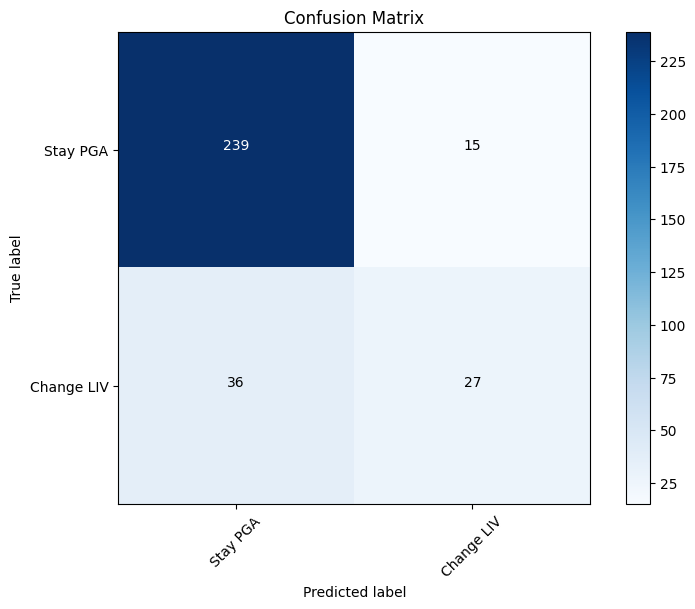

In [23]:
# Compute confusion matrix
cm = confusion_matrix(y_train_resampled, train_predictions)

# Define class labels
classes = ['Stay PGA', 'Change LIV']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Fill confusion matrix values
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

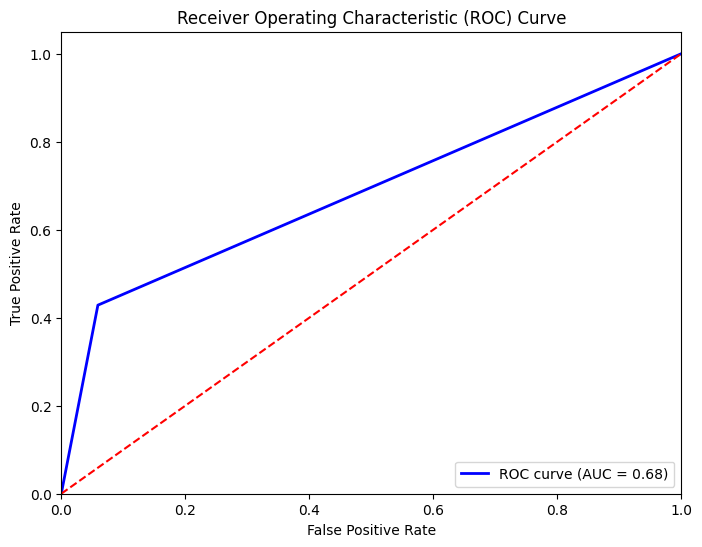

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming train_predictions and y_train_resampled are your predicted probabilities and true labels respectively
# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_train_resampled, train_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Predicting 3 months a-head sentiment

27    0.888359
28    0.881089
29    0.880554
30    0.880514
31    0.880512
Name: predicted_mean, dtype: float64


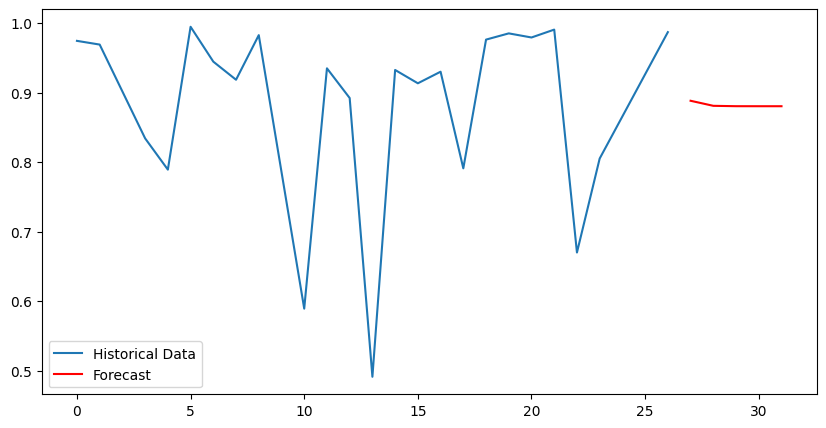

In [24]:
## Current PGA Players - We want to predict their future sentiment and use it to predict their probability of switching.

spieth_ts = df['sent_pga'][df['player'] == 'jordan spieth'].reset_index(drop=True)
thomas_ts = df['sent_pga'][df['player'] == 'justin thomas'].reset_index(drop=True)
morikawa_ts = df['sent_pga'][df['player'] == 'collin morikawa'].reset_index(drop=True)

Predictions = []
merged_data = spieth_ts.merge()

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

p = 1  # AR term
d = 1  # differencing
q = 1  # MA term

# Fit the ARIMA model
model = ARIMA(spieth_ts, order=(p, d, q))
model_fit = model.fit()

# Forecast the next 3 periods
forecast = model_fit.forecast(steps=5)
print(forecast)

# Optional: Plotting the forecast along with the historical data
plt.figure(figsize=(10, 5))
plt.plot(spieth_ts, label='Historical Data')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.show()

### We created further observations out of an ARMA(1,1) model. We would treat this observations as out of sample (testing) to evaluate the model performance.